### XGBoost

  - 이제는 xgboost. 이 방법은 부트스트랩이 아닌 부스팅을 이용한다. 부트스트랩이 랜덤한 샘플을 여러개 뽑은 방법이라면,
    부스팅은 병렬적이 아닌 연속적으로 진행한다는 점에서 그 차이점을 가진다. 즉 하나의 트리에서 시작하여 잔차를 계속해서
    줄여나가는 방향으로 트리를 학습시키는 것이다.

  - GBM은 역시 약한 트리를 만들어서 잔차를 줄여가는 방향으로 만들어지는 방법이다. 잔차를 최대한 줄이기 위한 잔차에 대한
    모델링을 진행하고, 약한 트리로부터 최종적으로는 완벽한 트리를 만든다. 경사하강법이기때문에 최적의 에러지점을 뛰어넘지
    않기 위해 약한 모델을 사용하는 것이다.

  - XGB는 이러한 GBM 모델을 발전시킨 것. 다양한 파라미터를 조정할 수 있고 NA를 자동처리해주고, sparse
    matrix를 처리해주고, information gain을 사용해 classification 할때 좋다고 한다.

  - Loss function + regularization function으로 objective function가 구성돼
    있다. Lossfunction은 뭐 MSE나 로지스틱 리그레션 등이 있다.

  - 그 다음 최적화 방식(손실함수의 결과 값을 최소화하는 방법)으로는 경사하강법을 사용하는 것

**튜닝할 수 있는 파라미터들은 다음과 같다**

> 1)  max/_depth : 라운드 한개당 만들어지는 나무의 깊이/! 나무가 깊어질수록 복잡도가 증가하여 분산이 증가하고
>     **오버피팅**이 발생할 수 있다고 한다.. 디폴트 값은 6이고 1부터 무한까지 값을 가진다.

> 2)  min/_child/_weight : 라운드당 한 트리의 마지막 노드에 남는 obs의 개수 혹은 IG(가중치)의 양/!
>     클수록 분산은 down, 편향은 up default : 1

> 3)  eta : Learning rate(학습률), 작을수록 더 촘촘하게 최적점을 찾아 내려간다.(경사하강법),
>     default : 0.3 이걸 줄이면 nround는 늘려야 한다

> 4)  gamma : 손실함수를 조정하는 파라미터 default : 0(정규화 안해/!) 그리고 lambda(L2
>     regression, 디폴트는 1), alpha(L1 regression, 디폴트는 0)도 정규화 파라미터로 존재한다.

> 5)  nrounds : 최대 반복 횟수. 아까 말했듯 많이 하면 할수록 성능은 좋아지나 overfitting/!/!/!
>     default : 100. early stopping rounds 변수로 overfitting을 조정 가능하다.

> 6)  early/_stopping/_rounds : CV 할 때 이용 가능, 최적의 error를 가진 라운드 선정 ,
>     Validation error 가 지정한 라운드가 지나도록 감소하지 않으면 학습을 중단하고 최적의 validation
>     error가 나온 round 선정. (nrounds를 굉장히 크게 지정하고 early stopping rounds로
>     overfitting 방지)

> 7)  colsample/_bytree : 매 반복 시 추출할 열의 비율. 0/~1이고 default는 1

> 8)  subsample : 샘플링하는 obs의 비율, default : 1

> 9)  eval/_metric : 평가지표/! rmse,mae, logloss , error(Binary
>     classification error rate (0.5 threshold), merror – Multiclass
>     classification error rate, mlogloss – Multiclass logloss, auc -
>     Area under the curve


In [37]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#### 1) Data scan

In [2]:
score = pd.read_csv("C:/Users/jiho0/Desktop/Data_Analysis/(p-sat)package/2018_2/week4/scores.csv", index_col = 0)
score.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
5,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 1 to 1044
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

In [4]:
score.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


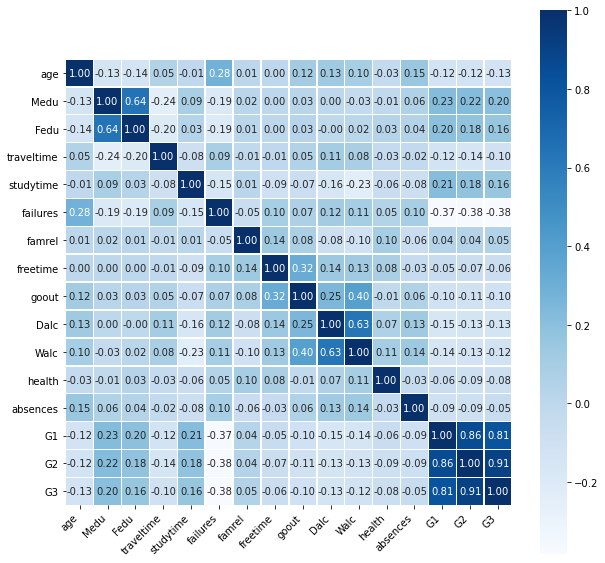

In [5]:
plt.figure(figsize = (10,10))


ax = sns.heatmap(score.corr(), annot = True, fmt = '.2f', linewidths = 0.5, square = True,   cmap= 'Blues')

ax.set_xticklabels(
    ax.get_xticklabels(), rotation = 45,horizontalalignment='right' )

plt.show()

흠 저 G1 G2 G3의 correlation이 상당히 높으므로 PCA를 진행해보자.

#### 2) PCA - correlation 해결

근데 우리가 예측하려는 target값인데 PCA로 왜곡을 줘도 되는 건가?
일단 진행해보자

In [6]:
from sklearn.decomposition import PCA
# import plotly.express as px

pca = PCA()
pca.fit(score[['G1', 'G2', 'G3']])

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
exp_var_cumul
#하나의 PC로 세 데이터의 분산을 91%나 설명할 수 있다. 생각보다 성능이 좋은듯

array([0.91162156, 0.97264198, 1.        ])

In [7]:
pca = PCA(n_components=1)
pca_fit = pca.fit_transform(score[['G1', 'G2', 'G3']])
pca_fit_data = pd.DataFrame(data = pca_fit, columns = ['PC1'])
pca_fit_data.describe()
#음수값이 나와서 안될 것 같다.

,PC1
count,1.044000e+03
mean,6.562439e-16
std,5.618587e+00
min,-1.393681e+01
25%,-3.630598e+00
50%,-1.379049e-02
75%,3.240208e+00
max,1.742698e+01


#### 3) 데이터 전처리

In [8]:
#더미변수화 
score1 = pd.get_dummies(score, drop_first = True, dtype= 'int64')

score1.head(5)
print(score1.columns)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')


In [9]:
score1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 1 to 1044
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                1044 non-null   int64
 1   Medu               1044 non-null   int64
 2   Fedu               1044 non-null   int64
 3   traveltime         1044 non-null   int64
 4   studytime          1044 non-null   int64
 5   failures           1044 non-null   int64
 6   famrel             1044 non-null   int64
 7   freetime           1044 non-null   int64
 8   goout              1044 non-null   int64
 9   Dalc               1044 non-null   int64
 10  Walc               1044 non-null   int64
 11  health             1044 non-null   int64
 12  absences           1044 non-null   int64
 13  G1                 1044 non-null   int64
 14  G2                 1044 non-null   int64
 15  G3                 1044 non-null   int64
 16  school_MS          1044 non-null   int64
 17  sex_M         

In [10]:
#상관관계 분석
score1.corrwith(score1['G3'])[score1.corrwith(score1['G3']) > 0.7]

G1    0.809142
G2    0.910743
G3    1.000000
dtype: float64

G1과 G2는 상관성이 상당히 뚜렷하므로 제외하고 데이터를 분석

In [11]:
score2 = score1.drop(['G1' ,'G2'], axis = 1)

In [12]:
x, y = score1.drop(['G3'], axis = 1), score['G3']

In [13]:
train_data, holdout_data, train_label, holdout_label = train_test_split(x, y, test_size = 0.3,
                                                                       random_state = 1234)
print("train_Data's shape : {0}".format(train_data.shape))
print("train_label's shape : {0}".format(train_label.shape))
print("holdout_data's shape : {0}".format(holdout_data.shape))
print("holdout_label's shape : {0}".format(holdout_label.shape))

#xgb용 데이터로 만들어준다.
train_set = xgb.DMatrix(data = train_data, label = train_label)
holdout_set = xgb.DMatrix(data = holdout_data, label = holdout_label)

train_Data's shape : (730, 41)
train_label's shape : (730,)
holdout_data's shape : (314, 41)
holdout_label's shape : (314,)


> xgb.cv() : 주어진 하나의 파라미터로 cv를 돌려서 결과값을 내주는 것인데, ealry_stopping_rounds를 통해서 어느정도의 n_estimator가 적절한지 판단할 수 있다.

> cross_val_score : 내가 원했던 것. GridSearchCV로 찾았던 파라미터를 넣었을때 어떤 CV_mean_error가 도출되는지 나오게 된다.

> GridSearchCV : 내가 원하는 gridsearch를 진행!


<span style="color:blue">
    
주의해야 할 것은 같은 파라미터를 넣어도 xgb.cv()와 GridSearchCV의 값이 다르게 나온다는 것이다.(그리드 서치의 값을 하나의 값만 넣어줌에도 불구하고...

아마 디폴트로 지정된 값이 다르거나, seed가 달라서 다른 cv가 생성되는 것일 수 있다.
   
</span>

#### 4-1) GridSearch로 parameter tuning

파라미터 튜닝은 한번에 하는 방법도 있지만, 한 블로그에선 좋은 기준을 만들어서 제공하고 있었다.
대충 기준은 
1) learning rate 하나를 잡고, 거기에 최적화된 n_estimators(tree의 개수)를 찾는다.
> 0.1도 되긴 하는데 보통 0.05부터 0.3 정도를 잡는다고 한다.
> n_estimators : Number of gradient boosted trees. Equivalent to number of boosting rounds.

2) (tree-specific parameter) max_depth와 min_child_weight
>  이 두개가 큰 영향을 미친다고 한다. 
> max_depth는 3 ~ 10 정도에서 튜닝! min_child_weight도 1~6정도로 튜닝한다.

3) (정규화 파라미터)gamma를 튜닝한다.

4) subsample과 colsample_bytree를 튜닝한다.
> 한번에 뽑는 샘플의 %와, 사용하는 변수의 %를 결정! 여기선 0.6 ~ 1로 설정했다.

5) (정규화 파라미터)reg_alpha와 reg_lambda를 튜닝
> gamma도 정규화 파라미터라서 이를 잘 안해준다고 한다.

6) learning rate를 줄이고 n_estimators의 값을 늘려서 최적의 파라미터를 찾는다!

####  step1) learning rate에 최적화된 n_estimators 값 찾기

이 과정이 상당히 중요한 이유는, 과적합을 방지하는 단계이기 때문이다. 

당연히 nround(n_estimator)가 커지면 테스트 셋에 상당히 fit된 모델을 얻게 된다. 
따라서 이를 방지하기 위해, 해당 learning rate에 최적화된 n_estimator의 값을 찾는 것이다.

In [14]:
#Warning을 안뜨게 하기 위해 파라미터 직접 지정...
param1 = {
 "learning_rate" : 0.1,
#  "n_estimators" : 1000,
 "max_depth" : 5,
 "min_child_weight" : 1,
 "gamma" : 0,
 "subsample" : 0.8,
 "colsample_bytree" : 0.8,
 "seed" : 1234
}

xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = 1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
#  nthread =4,병렬처리의 개수인 것 같다. 디폴트로 하면 최대!
#  scale_pos_weight = 1,
 seed = 1234)

In [19]:
#learning rate 0.1에 가장 적합한 n_estimator를 찾자

#확정된 파라미터에 대해 xgb.cv진행. early_stopping_rounds로 짧은 iteration을 찾는다.
cv_result = xgb.cv(param1, train_set, nfold = 5, num_boost_round = 1000, metrics = 'rmse')

#learning rate에 대한 최적의 nrounds 저장 
nround = cv_result[['test-rmse-mean']].idxmin()

#해당 값들 출력
print("nround : {0}".format(nround[0]))
print("cv_mean_error : {0}".format(cv_result.loc[cv_result[['test-rmse-mean']].idxmin()][['test-rmse-mean']]))

#업데이트된 iteration을 sk-learn wrapper에 다시 저장한다
xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = nround[0],
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
#  nthread =4,병렬처리의 개수인 것 같다. 디폴트로 하면 최대!
#  scale_pos_weight = 1,
 seed = 1234)

nround : 42
cv_mean_error :     test-rmse-mean
42        1.590353


- 실제로 nround가 늘어날때 RMSE의 그래프를 살펴보자

여기서 알 수 있는 것은, nround가 늘어난다고 해서 cv-error(RMSE)가 무조건 줄어드는 것은 아니라는 것이다. 오히려 과적합되어 validation으로 사용되는 데이터에 대해서는 좋은 성능을 보이지 못할 수 있다.

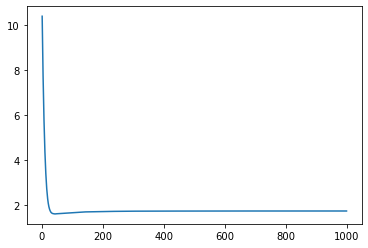

In [20]:
plt.figure()
x = np.arange(1,1001)
plt.plot(x, cv_result[['test-rmse-mean']])
plt.show()

#### Step2) max_depth와 min_child_weight Tuning

In [21]:
#max_depth와 min_child_weight의 grid 지정
param_step2 = {
    'max_depth' : range(3,10,1),  #시간이 좀 걸려도 1씩 증가하게 해주면 더 한번에 찾을 수 있을 것이다.
    'min_child_weight' : range(1,6,1)
}

#그리드서치 진행
gsearch_step2  = GridSearchCV(estimator = xgb2, 
                                  param_grid = param_step2, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1) #n_jobs는 병렬처리로 한다는 뜻인 것 같다.


gsearch_step2.fit(train_data,train_label)

#최적의 파라미터를 추출한다.
print("best parameter:", gsearch_step2.best_params_)
print("best score : ", -gsearch_step2.best_score_)

#max_depth, min_child_weight를 저장하자
xgb3 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = nround[0],
 max_depth = gsearch_step2.best_params_['max_depth'],
 min_child_weight=gsearch_step2.best_params_['min_child_weight'],
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 seed =1234)

#파라미터별 cv_mean 한눈에 보기
cv_result_step2 = pd.DataFrame(gsearch_step2.cv_results_)
cv_result_step2.sort_values(by = ['rank_test_score'], inplace = True)
cv_result_step2[['params', 'mean_test_score', 'rank_test_score']].head(5)

best parameter: {'max_depth': 3, 'min_child_weight': 3}
best score :  1.520427327921387


,params,mean_test_score,rank_test_score
2,"{'max_depth': 3, 'min_child_weight': 3}",-1.520427,1
3,"{'max_depth': 3, 'min_child_weight': 4}",-1.520450,2
0,"{'max_depth': 3, 'min_child_weight': 1}",-1.531974,3
9,"{'max_depth': 4, 'min_child_weight': 5}",-1.536658,4
4,"{'max_depth': 3, 'min_child_weight': 5}",-1.536857,5


- 싸이킷 런에서는 독특하게 최대를 찾는 함수를 적용한다고 한다. 그래서 scoring도 negative_mean_squared_error!
- 실제로는 저기에 음수를 취해준 값이 우리의 cv_mean이다.
- 실제로 test rmse가 줄어들었다!

#### Step3) Gamma Tuning

In [22]:
#gamma에 대한 grid를 설정
param_step3 = {
    'gamma':[i/10.0 for i in range(0,5)]  
}


gsearch_step3  = GridSearchCV(estimator = xgb3, #아까 max_depth, min_child_weight의 값을 바꿔준 모델!
                                  param_grid = param_step3, scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1) #n_jobs는 병렬처리로 한다는 뜻인 것 같다.

gsearch_step3.fit(train_data,train_label)

#최적 파라미터 설정
print("best parameter:", gsearch_step3.best_params_)
print("best score : ", -gsearch_step3.best_score_)

#gamma의 값 저장

xgb3 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = nround[0],
 max_depth = gsearch_step2.best_params_['max_depth'],
 min_child_weight = gsearch_step2.best_params_['min_child_weight'],
 gamma=gsearch_step3.best_params_['gamma'],
 subsample=0.8,
 colsample_bytree=0.8,
 seed =1234)

#파라미터별 cv_mean 한눈에 보기
cv_result_step3 = pd.DataFrame(gsearch_step3.cv_results_)
cv_result_step3.sort_values(by = ['rank_test_score'], inplace = True)
cv_result_step3[['params', 'mean_test_score', 'rank_test_score']].head(5)

best parameter: {'gamma': 0.0}
best score :  1.520427327921387


,params,mean_test_score,rank_test_score
0,{'gamma': 0.0},-1.520427,1
2,{'gamma': 0.2},-1.520591,2
1,{'gamma': 0.1},-1.520611,3
4,{'gamma': 0.4},-1.525688,4
3,{'gamma': 0.3},-1.525691,5


이번에도 cv_error가 아주 미세하게나마 줄어들었다.

#### Step4) Tuning subsample and colsample_bytree

In [23]:
param_step4 = {
    'subsample' : [i/10.0 for i in range(4,10)],
    'colsample_bytree' : [i/10.0 for i in range(4,10)]
}

gsearch_step4  = GridSearchCV(estimator = xgb3, #gamma와 nround를 재정비해준 모형
                                  param_grid = param_step4, scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1) #n_jobs는 병렬처리로 한다는 뜻인 것 같다.
gsearch_step4.fit(train_data,train_label)

#CV값 추출
print("best parameter:", gsearch_step4.best_params_)
print("best score : ", -gsearch_step4.best_score_)

#subsample & colsample_bytree를 저장하자
xgb4 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = nround[0],
 max_depth = gsearch_step2.best_params_['max_depth'],
 min_child_weight = gsearch_step2.best_params_['min_child_weight'],
 gamma=gsearch_step3.best_params_['gamma'],
 subsample=gsearch_step4.best_params_['subsample'],
 colsample_bytree=gsearch_step4.best_params_['colsample_bytree'],
 seed =1234)

#파라미터별 cv_mean 한눈에 보기
cv_result_step4 = pd.DataFrame(gsearch_step4.cv_results_)
cv_result_step4.sort_values(by = ['rank_test_score'], inplace = True)
cv_result_step4[['params', 'mean_test_score', 'rank_test_score']].head(5)

best parameter: {'colsample_bytree': 0.7, 'subsample': 0.7}
best score :  1.4959195058503554


,params,mean_test_score,rank_test_score
21,"{'colsample_bytree': 0.7, 'subsample': 0.7}",-1.495920,1
23,"{'colsample_bytree': 0.7, 'subsample': 0.9}",-1.504844,2
16,"{'colsample_bytree': 0.6, 'subsample': 0.8}",-1.507883,3
22,"{'colsample_bytree': 0.7, 'subsample': 0.8}",-1.508365,4
17,"{'colsample_bytree': 0.6, 'subsample': 0.9}",-1.509503,5


#### Step5) Tuning Regularization Parameters

In [24]:
param_step5 = {
    'reg_alpha' : [0, 1e-5, 1e-2, 0.1, 1], #default = 0
    'reg_lambda' : [0, 1e-5, 1e-2, 0.1, 1] #default = 1
}

gsearch_step5  = GridSearchCV(estimator = xgb4, #colsample_bytree와 subsample을 재정비해준 모형
                                  param_grid = param_step5, scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1) #n_jobs는 병렬처리로 한다는 뜻인 것 같다.
gsearch_step5.fit(train_data,train_label)

#CV값 추출
print("best parameter:", gsearch_step5.best_params_)
print("best score : ", -gsearch_step5.best_score_)

#alpha, lambda를 저장하자.
xgb5 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = nround[0],
 max_depth = gsearch_step2.best_params_['max_depth'],
 min_child_weight = gsearch_step2.best_params_['min_child_weight'],
 gamma=gsearch_step3.best_params_['gamma'],
 subsample = gsearch_step4.best_params_['subsample'],
 colsample_bytree = gsearch_step4.best_params_['colsample_bytree'],
 reg_alpha = gsearch_step5.best_params_['reg_alpha'],
 reg_lambda = gsearch_step5.best_params_['reg_lambda'],
 seed =1234)

#파라미터별 cv_mean 한눈에 보기
cv_result_step5 = pd.DataFrame(gsearch_step5.cv_results_)
cv_result_step5.sort_values(by = ['rank_test_score'], inplace = True)
cv_result_step5[['params', 'mean_test_score', 'rank_test_score']].head(5)

best parameter: {'reg_alpha': 0, 'reg_lambda': 1}
best score :  1.4959195058503554


,params,mean_test_score,rank_test_score
4,"{'reg_alpha': 0, 'reg_lambda': 1}",-1.495920,1
9,"{'reg_alpha': 1e-05, 'reg_lambda': 1}",-1.495920,2
19,"{'reg_alpha': 0.1, 'reg_lambda': 1}",-1.496896,3
14,"{'reg_alpha': 0.01, 'reg_lambda': 1}",-1.497198,4
24,"{'reg_alpha': 1, 'reg_lambda': 1}",-1.497283,5


> 알파와 람다는 바뀌지 않았다. 실제로 디폴트 값을 적용했을 때 RMSE가 가장 낮으므로 해당 부분을 사용한다

- 최종적으로 설정된 파라미터에 대해 최적의 nrounds를 한번 찾아보자

In [32]:
#Warning을 안뜨게 하기 위해 파라미터 직접 지정...
param3 = {
 "learning_rate" : 0.1,
#  "n_estimators" : 1000,
 "max_depth" : gsearch_step2.best_params_['max_depth'],
 "min_child_weight" : gsearch_step2.best_params_['min_child_weight'],
 "gamma" : gsearch_step3.best_params_['gamma'],
 "colsample_bytree" : gsearch_step4.best_params_['colsample_bytree'],
 "reg_alpha" : gsearch_step5.best_params_['reg_alpha'],
 "reg_lambda" : gsearch_step5.best_params_['reg_lambda'],
}


#cv를 돌려서 현재까지 가진, 1)learning rate 2)max_depth 3)min_child_weight 4)gamma 5)colsample_bytree 6)alpha 7)gamma에
#최적의 nround값을 다시 한번 산정해줘서, 최적의 파라미터를 찾아본다.

#cv진행
cv_result2 = xgb.cv(param3 ,train_set, nfold = 5, num_boost_round = 1000, metrics = 'rmse', seed=1234)

#iteration의 최소값을 저장해준다.
nround2 = cv_result2[['test-rmse-mean']].idxmin()[0]

#최종 파라미터를 적용한 XGB parameter를 가진 xgb model을 만들어준다.
xgb_fin = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators = nround2,
 max_depth = gsearch_step2.best_params_['max_depth'],
 min_child_weight = gsearch_step2.best_params_['min_child_weight'],
 gamma=gsearch_step3.best_params_['gamma'],
 subsample = gsearch_step4.best_params_['subsample'],
 colsample_bytree = gsearch_step4.best_params_['colsample_bytree'],
 reg_alpha = gsearch_step5.best_params_['reg_alpha'],
 reg_lambda = gsearch_step5.best_params_['reg_lambda'],
 seed =1234)

print("nround : ", nround2)
print("CV_error : {0}".format(np.mean(cross_val_score(xgb_fin, X = train_data, y = train_label, cv = 5, scoring = 'neg_root_mean_squared_error'))))

nround :  55
CV_error : -1.4950701974588199


nround가 42 -> 55로 바뀌면서 RMSE가 1.4959 -> 1.4950으로 소폭 개선됨을 파악할 수 있다.

#### Step6) Reducing Learning Rate

learning rate를 줄이고 tree의 개수를 늘려보자

In [39]:
#우리가 가진 파라미터에 대해 진행하는 것인줄은 모르겠다.

param4 = {
 "learning_rate" : 0.05, #learning_rate를 상당히 줄이고
#  "n_estimators" : 1000,
 "max_depth" : gsearch_step2.best_params_['max_depth'],
 "min_child_weight" : gsearch_step2.best_params_['min_child_weight'],
 "gamma" : gsearch_step3.best_params_['gamma'],
 "colsample_bytree" : gsearch_step4.best_params_['colsample_bytree'],
 "reg_alpha" : gsearch_step5.best_params_['reg_alpha'],
 "reg_lambda" : gsearch_step5.best_params_['reg_lambda'],
}

#nround를 찾는다.
cv_result3 = xgb.cv(param3 ,train_set, nfold = 5, num_boost_round = 10000, metrics = 'rmse', seed=1234)

#iteration의 최소값을 저장해준다.
nround3 = cv_result3[['test-rmse-mean']].idxmin()[0]

#최종 파라미터를 적용한 XGB parameter를 가진 xgb model을 만들어준다.
xgb_fin2 = xgb.XGBRegressor(
 learning_rate =0.05,
 n_estimators = nround3,
 max_depth = gsearch_step2.best_params_['max_depth'],
 min_child_weight = gsearch_step2.best_params_['min_child_weight'],
 gamma=gsearch_step3.best_params_['gamma'],
 subsample = gsearch_step4.best_params_['subsample'],
 colsample_bytree = gsearch_step4.best_params_['colsample_bytree'],
 reg_alpha = gsearch_step5.best_params_['reg_alpha'],
 reg_lambda = gsearch_step5.best_params_['reg_lambda'],
 seed =1234)

print("nround : ", nround3)
print("CV_error : {0}".format(np.mean(cross_val_score(xgb_fin2, X = train_data, y = train_label, cv = 5, scoring = 'neg_root_mean_squared_error'))))

nround :  55
CV_error : -1.6768348484938727


> 근데 오히려 learning rate를 촘촘하게 가져감으로써 local min에 빠져버리는 것 같다. 0.1로 잡았을 때보다 RMSE값이 더 높아짐을 볼 수 있다.

#### 4-2) 최종 파라미터로 holdout을 예측해보자

In [38]:
#모형학습
xgb_final = xgb_fin.fit(train_data, train_label, eval_metric = 'rmse')

#train 전체에 대한 error
xgb_pred_train = xgb_final.predict(train_data)

#holdout set 예측!
xgb_pred_holdout = xgb_final.predict(holdout_data)

#성능 산출
print("cv_error_평균 : ", -gsearch_step5.best_score_)
print("train_error : {0}".format(np.sqrt(metrics.mean_squared_error(xgb_pred_train, train_label))))
print("holdout_error : {0}".format(np.sqrt(metrics.mean_squared_error(xgb_pred_holdout, holdout_label))))

cv_error_평균 :  1.4959195058503554
train_error : 1.2150595076986628
holdout_error : 1.4275365538938654
